# Zynq PS with CRC

This Notebook demonstrates the working of a 32bit CRC Accelerator integrated with the Processing System(PS) present in the Zynq 7000 SoC.
The CRC IP is a Verilog Module present the Programmable Logic(PL) region of the SoC.

## Block Diagram of the Demonstrated Hardware

TODO - Add block diagram and Explain it here

### Importing the required packages

In [212]:
# Xilinx PyPi Package import
from pynq import Overlay
from pynq import MMIO

# Non-Xilinx Python package imports
import os
import numpy as np
import binascii
from PIL import Image
import cv2
import random as random
from matplotlib import pyplot as plt

import pandas as pd
from IPython.display import display

import crcmod.predefined
from codecs import decode as decode

# to display the image within the jupyter notebook
%matplotlib inline

### Set up other Handwritten functions

#### Function to load an image and convert it into a list of 32bit hexadecimal values

In [120]:
"""
    Function to return the list of hex values when given a file name
    input: string = Path to the file
    returns: list = the file sliced into 32bit hex elements
"""
def return_hex_list(file):
    
    # read the file
    # the file size is 4kb for the examples we use
    with open(file, 'rb') as f:
        content = f.read()
    
    # print the length of the bytestream
    print("length of the bytestream: ", len(content))
    
    # the list will contain 4bytes per element in hex format
    # converting the image data from bytes to hex will lead to a size increase
    temp_val = content.hex()
    len_tv = len(temp_val)
    
    # print the length of the bytestream
    print("length of the hex stream of the image: ", len_tv)    
    
    # we find the closest power of two to pad the stream
    if (len_tv > 1):
        for i in range(1, len_tv):
            if (2**i >= len_tv):
                size = 2**i
                break
    
    print("length the hex stream: ", size)
    
    st = temp_val.ljust(size,'0')
    hex_list = []
    
    for i in range(0, len(st), 8):
        #print(st[i], st[i+1], st[i+2], st[i+3])
        #print(int(st[i], 16), int(st[i+1], 16), int(st[i+2], 16), int(st[i+3], 16))
        hex_list.append(((int(st[i]  , 16) << 28) | \
                         (int(st[i+1], 16) << 24) | \
                         (int(st[i+2], 16) << 20) | \
                         (int(st[i+3], 16) << 16) | \
                         (int(st[i+4], 16) << 12) | \
                         (int(st[i+5], 16) <<  8) | \
                         (int(st[i+6], 16) <<  4) | \
                         (int(st[i+7], 16))))   
    
    # print the number of 32bit elements in the list
    print("number of 32bit elements in the list: ", len(hex_list))
    print("size of the image", 4*(len(hex_list)), "Bytes")
    
    return hex_list

#### Inject random noise into a hex list.

In [437]:
# noise can affect both data and crc value
def noisy(x, threshold):
    for i in range (len(x)):
        if random.randint(0, 1000) > threshold:
            x[i] = x[i] ^ random.randint(0, 2^32) & 0xFFFFFFFF
        else:
            x[i] = x[i]
    return x

#### CRC computation with software library

In [176]:
def soft_crc(value):
    # convert the input stream into bytes
    value = value.replace("0x", "")
    value = value.rjust(8, '0')
    value = decode(value, 'hex_codec')
    
    crc32_func = crcmod.predefined.mkCrcFun('crc-32-mpeg')
    res = crc32_func(value)
    return res

#### Convert a Hex list into an image

In [379]:
def hex_to_img(hex_list, filename):
    hex_img = []

    for i in range(0, len(hex_list)):
        hex_img.append(hex(hex_list[i]).replace("0x", '').rjust(8, "0"))
    
    hex_img = codecs.decode(''.join(hex_img), 'hex_codec')
    with open(filename, 'wb') as f:
        f.write(hex_img)
    return(filename)

### Creation of the Overlay with the Bitstream

In [39]:
ol = Overlay("crc_mpeg2.bit")

### Setting up the Memory Regions

The CRC IP and the BRAM present in the PL are interfaced as Memory Mapped IPs interacting with the PS through AXI4-Lite.

In [40]:
# Base address of the CRC IP
base_address_crc = 0x43C00000
# Base address of the BRAM
base_address_mem = 0x40000000

# Size of the Memory(In Bytes) mapped to the IP memory/registers in the PS address space
# CRC has 4 registers of 32bit width
crc_regmem_size = 128

# The BRAM size is 8kB
bram_mem_size = 8192

### Creating MMIO objects to interact with the Memory Mapped IPs

In [46]:
# Object to interact with the CRC IP
mmio_crc = MMIO(base_address_crc, crc_regmem_size)
# Object to interact with the BRAM IP
mmio_bram = MMIO(base_address_mem, bram_mem_size)

#### Set up address offsets for the MMIO

In [47]:
# we use ofsets to read from the MMIO AXI CRC IP
crc_address_offset = 0x0

# we use ofsets to read from the MMIO AXI BRAM
bram_address_offset = 0x0

#### Clear the BRAM and write zeros into it.

In [131]:
for i in range(0, int(bram_mem_size/4)):
    # Since memory in AXI is byte Addresses, and the access granularity is 4bytes
    # the offset should be a multiple of 4
    mmio_bram.write(bram_address_offset+(i*4), 0)

#### Clear the CRC input registers and write zeros into it.

In [132]:
mmio_crc.write(crc_address_offset,0)
mmio_crc.write(crc_address_offset+0x4, 0)

### Read an image and Store it in the BRAM

The size of the BRAM is 8kB. The image is chosen to be smaller than that.

![Test Image](.\test_image.png)

In [133]:
# path to the file
file = "./test_image.png"
# read the file and convert it into a list of hexadecimal values
# img_hex = [0xbabecafe, 0xdeadbeef, ..., 0xdeadcafe]
img_hex = return_hex_list(file)

length of the bytestream:  3987
length of the hex stream of the image:  7974
length the hex stream:  8192
number of 32bit elements in the list:  1024
size of the image 4096 Bytes


Write into the BRAM

In [225]:
for i in range(0, len(img_hex)):
    # Since memory in AXI is byte Addresses, and the access granularity is 4bytes
    # the offset should be a multiple of 4
    mmio_bram.write(bram_address_offset+(i*4), img_hex[i])

print("written data into the 8kB BRAM")

written data into the 8kB BRAM


## Demonstration of CRC Accelerator detecting error occuring during transmission

The Image stored in the BRAM will be transmitted to the receiver along with the CRC of the image.

### CRC MPEG2 (IEEE 802.3) Specific Setup
The initial value is fixed to 0xFFFFFFFF for IEEE 802.3

In [226]:
crc_initial_data = 0xffffffff

The CRC IP will read directly from the BRAM and perform the CRC Calculation.
The output from the CRC, and the image are stored in a buffer

_Ideally this will then get transmitted to the world._

But for demonstration, we **do not** send the data out but write it into a _output buffer_.

We then copy the data from the _output buffer_ to the _input buffer_ and perform our check on it.
This copy operation is expected to mimic a data transfer.

The Jupyter notebook functions like a controller interfacing between the CRC IP and the BRAM.

### Transmitter End

In [438]:
# The output buffer contains the image and the associated CRC at 4byte granularity
# output_buffer = [img[0], crc32(img[0]), img[1], crc32(img[1]), ......]
output_buffer = []

for i in range(len(img_hex)):
    output_buffer.append(mmio_bram.read(i*4))
    mmio_crc.write(crc_address_offset, output_buffer[i*2])
    mmio_crc.write(crc_address_offset+0x4, crc_initial_data)
    output_buffer.append(mmio_crc.read(0x8))

### Receiver End

The receiver will receive 32 bit packets.
The order of packets is

Packet 1 - Image[0:31]

Packet 2 - CRC of Packet[1]

...

Packet n-1 - Image[n-31:n]

Packet n - CRC of Packet[n]

In [409]:
# Mimic the transmission
input_buffer = output_buffer

# The input_buffer will feed two separate buffers, CRC buffer and data buffer
data_input_buffer = []
crc_input_buffer = []

# distribute the data to the two dedicated buffers
for i in range(0, len(input_buffer), 2):
    data_input_buffer.append(input_buffer[i])
    crc_input_buffer.append(input_buffer[i+1])

calculated_crc_buffer = []
# we use ofsets to read from the MMIO AXI CRC IP
crc_address_offset = 0x0

for i in range(len(data_input_buffer)):
    mmio_crc.write(crc_address_offset, data_input_buffer[i])
    mmio_crc.write(crc_address_offset+0x4, crc_initial_data)
    calculated_crc_buffer.append(mmio_crc.read(0x8))

In [412]:
hex_to_img(data_input_buffer, './without_noise.png')

'./without_noise.png'

### The transmitted Image is

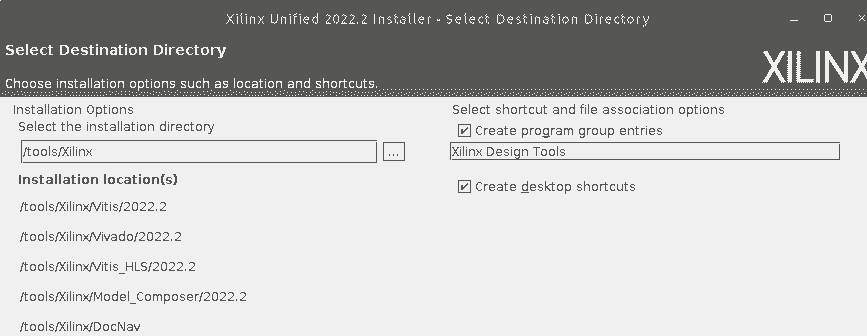

In [413]:
test_im = Image.open('./without_noise.png')
display(test_im)

#### Compare the Calculated CRC and the Received CRC

In [410]:
print("MATCH") if (crc_input_buffer == calculated_crc_buffer) else print("RESEND DATA")

MATCH


In [411]:
count = 0
for i in range(len(crc_input_buffer)):
    if (crc_input_buffer[i] != calculated_crc_buffer[i]):
        print('CRC mismatch for Data Element', i)
        count =  count + 1

print('Number of Mismatches', count)

Number of Mismatches 0


### Validate CRC

In [348]:
crc_output_buffer = []
software_crc_buffer = []

for i in range(1, len(output_buffer), 2):
    crc_output_buffer.append(hex(output_buffer[i]))

for i in range(0, len(output_buffer), 2):
    software_crc_buffer.append(hex(soft_crc(hex(output_buffer[i]))))

In [349]:
print("SW and HW CRC Match") if (crc_output_buffer == software_crc_buffer) else print("SW and HW CRC Mismatch")

SW and HW CRC Match


In [350]:
print('Size of the image in 32b granularity:', len(img_hex))
print('Size of the output_buffer:', len(output_buffer))


temp_img_hex = []
temp_output_buffer = []

for i in range(0, 10):
    temp_img_hex.append(hex(img_hex[i]))
for i in range(0, 20, 2):
    temp_output_buffer.append(hex(output_buffer[i+1]))

software_crc = []

# CRC results from software library
for i in range(0, 10):
    software_crc.append(hex(soft_crc(temp_img_hex[i])))
    
dict = {'CRC from Accelerator'      : temp_output_buffer,
        'CRC from software library' : software_crc,
        'Image in 32b Hex'          : temp_img_hex
        }

df = pd.DataFrame(dict)
df = df[['Image in 32b Hex', 'CRC from Accelerator', 'CRC from software library']]
display(df)

Size of the image in 32b granularity: 1024
Size of the output_buffer: 2048


,Image in 32b Hex,CRC from Accelerator,CRC from software library
0,0x89504e47,0x2bddbba1,0x2bddbba1
1,0xd0a1a0a,0x86633e6d,0x86633e6d
2,0xd,0xf6c95ba8,0xf6c95ba8
3,0x49484452,0x3e09d7e7,0x3e09d7e7
4,0x363,0x140962e6,0x140962e6
5,0x150,0x6d8ab7a0,0x6d8ab7a0
6,0x1030000,0x1900b245,0x1900b245
7,0x88e34,0xe3e58663,0xe3e58663
8,0x60000000,0xfcfe0bdf,0xfcfe0bdf
9,0x6504c54,0x89f3837b,0x89f3837b


## Let us Make it Noisy

In [445]:
# Data to input buffer witnesses noise and gets corrupted
input_buffer = noisy(output_buffer, 998)

In [446]:
# The input_buffer will feed two separate buffers, CRC buffer and data buffer
data_input_buffer = []
crc_input_buffer = []

# we use ofsets to read from the MMIO AXI CRC IP
crc_address_offset = 0x0

# distribute the data to the two dedicated buffers
for i in range(0, len(input_buffer), 2):
    data_input_buffer.append(input_buffer[i])
    crc_input_buffer.append(input_buffer[i+1])

calculated_crc_buffer = []

for i in range(len(data_input_buffer)):
    mmio_crc.write(crc_address_offset, data_input_buffer[i])
    mmio_crc.write(crc_address_offset+0x4, crc_initial_data)
    calculated_crc_buffer.append(mmio_crc.read(0x8))

Convert Hex to Image

In [449]:
hex_to_img(data_input_buffer, './with_noise.png')

'./with_noise.png'

### The transmitted Image is

The image is usually not printed due to data corruption

In [451]:
test_im = Image.open('./with_noise.png')
try:
    display(test_im) 
except Error as e:
    print(e.Error)

OSError: unrecognized data stream contents when reading image file

<PIL.PngImagePlugin.PngImageFile image mode=P size=867x336 at 0xA3E84F90>

In [447]:
print("MATCH") if (crc_input_buffer == calculated_crc_buffer) else print("RESEND DATA")

RESEND DATA


In [448]:
count = 0
for i in range(len(crc_input_buffer)):
    if (crc_input_buffer[i] != calculated_crc_buffer[i]):
        print('CRC mismatch for Data Element', i)
        count =  count + 1

print('Number of Mismatches', count)

CRC mismatch for Data Element 287
CRC mismatch for Data Element 864
CRC mismatch for Data Element 947
Number of Mismatches 3


Error can occur in both the Data as well as the CRC.

## Demonstrate Performance Over Software Libraries

In [ ]:
# read the image and display it
filename = './test_image.png'
pil_im = Image.open(filename)
#display(pil_im)

(336, 867, 3)


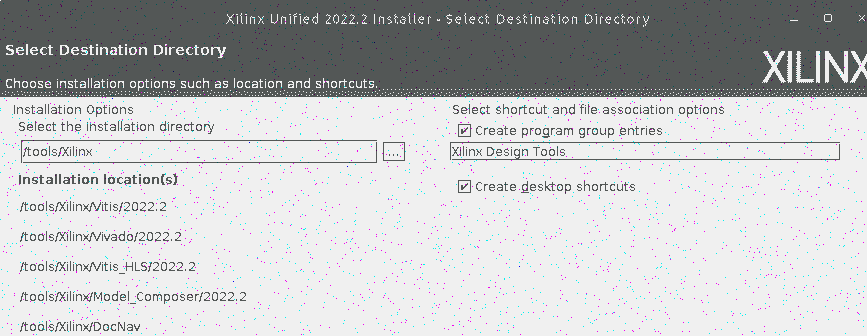

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


why


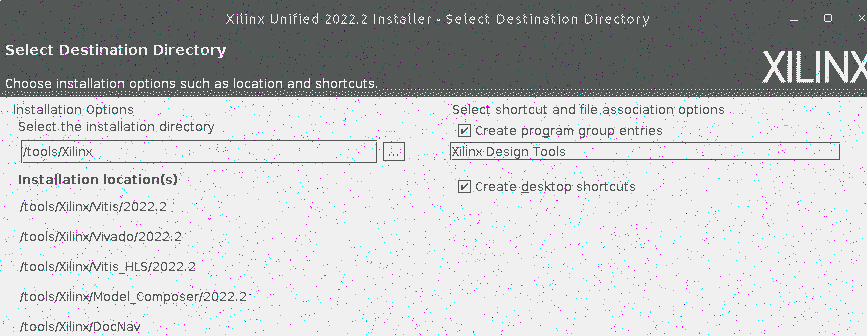

In [110]:
im = cv2.imread('./test_image.png')
test_im = Image.open('./test_image_peppers.png')
print(im.shape)
display(test_im)
# print(type(noisy("s&p", im)))
# plt.imshow(noisy("s&p", im))
# plt.show

im = Image.fromarray(noisy(im))
print("why")
display(im)
im.save('test_image_peppers.png', "PNG", optimize=True, quality=80)

In [84]:
# read the image as bytes
with open(filename, 'rb') as f:
    content = f.read()#.hex()
hex_val = binascii.hexlify(content)
#print(len(content))
#print((hex_val))

IndexError: string index out of range

In [8]:


#print(hex(hex_8k[0]))
#print(len(hex_8k))

0x36736e59
2048


In [46]:
import binascii
filename = './test_image.png'
with open(filename, 'rb') as f:
    content = f.read()
hex_val = binascii.hexlify(content)
#print((hex_val))



from PIL import Image
import cv2
#import skimage.util

#im = Image.open('./sahara.jpg')
#im = cv2.imread('./sahara.jpg')
#height, width, channels = im.shape

#print(width, height, channels)

import os

print(os.path.getsize('./test_image.png'))

3987


In [67]:
# change this to test with different CRC values
test_data = []
test_data.append(0xbabecafe)

# test_data.append(0xbabedafe) # - a5769b57
# test_data = 0x12345678 # - 0xdf808a2b

0xbabecb0e


In [72]:
# write the data to the accelerator
result = []
for i in range(0, 4096):
    mmio_crc.write(crc_address_offset, (test_data[0]+i))
    mmio_crc.write(crc_address_offset+0x4, crc_initial_data)
    result.append(mmio_crc.read(0x8))
#print((result))
count = 0
for n in result:
    if result.count(n)>1:
        count = count +1 
        # print("Repeated number: ",n, "Count: ", result.count(n))
print(count)

0


0xa5769b57


In [ ]:
#function to write input and read results
def crc_accel_test(test_data):
    # write the data to the accelerator
    #for i in range (0,1):
    mmio.write(address_offset, test_data)
    print(hex(test_data))
    mmio.write(address_offset+0x4, initial_data)
    # mmio.write(address_offset+0x8, 0x0)
    # read the result
    # result = []
    result = mmio.read(address_offset+0x8)
    return result

In [ ]:
for i in (0,1):
    print(hex(crc_accel_test(test_data[i])))
# %timeit -n 1000 crc_accel_test(0xbabecafe)

In [ ]:
## now, we, test PS!

In [ ]:
def create_table():
    a = []
    for i in range(256):
        k = i << 24;
        for _ in range(8):
            k = (k << 1) ^ 0x4c11db7 if k & 0x80000000 else k << 1
        a.append(k & 0xffffffff)
    return a

In [ ]:
def crc32(bytestream):
    crc = 0xffffffff
    crc_table = create_table()
    for byte in bytestream:
        lookup_index = ((crc >> 24) ^ byte) & 0xff
        crc = ((crc & 0xffffff) << 8) ^ crc_table[lookup_index]
    return crc

In [ ]:
initial_data_bytearray = bytearray.fromhex("babecafe")
print(initial_data_bytearray)

In [ ]:
print(hex(crc32(initial_data_bytearray)))
%timeit -n 1000 crc32(initial_data_bytearray)

In [ ]:
# now we test PS with library

In [ ]:
# s = b'\xba\xbe\xca\xfe'
#h = s.decode("hex")
#h = "0xbabecafe"
#b = bytearray(s)
def test(value):
    crc32_func = crcmod.predefined.mkCrcFun('crc-32-mpeg')
    res = crc32_func(value)
    return res

In [ ]:
print(hex(test(s)))
%timeit -n 1000 test(s)

In [44]:
pip list

SyntaxError: invalid syntax (<ipython-input-44-fbceae7be931>, line 1)